In [1]:
import numpy as np
import pandas as pd
from typing import List, Dict, Any

class Random:
    def __init__(self, n: int):
        """ n : int, number of targets (captions/videos/etc) """
        self.n = n

    def get_queries(self, n_queries: int ):
        indices = np.random.choice(self.n, n_queries, replace=True)
        return indices


    def partial_fit(self, answers: List):
        score_lbound_list = []
        for answer in range(len(answers)):
            total_scores = sum(answers[answer][1])
            hits = len(answers[answer][1])
            mean = total_scores / hits
            precs = (1 / (1e-8 + np.sqrt(hits)))
            upper_bound = mean + precs/2
            lower_bound = mean - precs/2
            score_lbound_list.append([mean, lower_bound, upper_bound])
        score_lbound_df = pd.DataFrame(score_lbound_list, columns=["mean", "lower_bound", "upper_bound"])
        score_lbound_df.sort_values(['mean', 'lower_bound'],ascending = [False, False])
        return score_lbound_df





In [3]:
NY_CapCont_table = pd.read_html('https://nextml.github.io/caption-contest-data/dashboards/803.html')
panda_table = pd.DataFrame(data=NY_CapCont_table[1])


def simulate_human_answer(panda_table, total_captions: int, trials: int):
    table = pd.DataFrame(data=panda_table)
    random_samplings = Random(total_captions)
    sampled_indicies = random_samplings.get_queries(trials)
    dic = {}
    for i in sampled_indicies:
        total_votes = table.at[i,'Total votes']
        nf_porp = (table.at[i,"\"Not funny\" votes"])/total_votes
        sf_porp = (table.at[i,"\"Somewhat funny\" votes"])/total_votes
        f_porp = (table.at[i,"\"Funny\" votes"])/total_votes
        score = int(np.random.choice(3, 1, p=[nf_porp, sf_porp, f_porp]) + 1)
        if i not in dic:
            dic[i] = []
            dic[i].append(score)
        else:
            dic[i].append(score)
        score_table = list(dic.items())
    
    score_precs_table = random_samplings.partial_fit(score_table)
        
    final=[]
    sorted_list = score_precs_table.sort_values(['mean', 'lower_bound'],ascending = [False, False])
    sorted_list = sorted_list.reset_index()
    sorted_list
    
    for i in range(len(sorted_list)):
        if sorted_list.at[0, "lower_bound"] <= sorted_list.at[i, "upper_bound"]:
            final.append([sorted_list.at[i, "mean"], sorted_list.at[i, "lower_bound"], sorted_list.at[i, "upper_bound"]])
    final = pd.DataFrame(final, columns=["mean", "lower_bound", "upper_bound"])
        
   
    return final


In [6]:
funniest_table = []

for x in range(10):
    if x == 0:
        y = 8000
        funniest_table.append([y,len(simulate_human_answer(NY_CapCont_table[1],len(panda_table),y))])
        print(x)
    else:
        y += (8000 + x*250)
        funniest_table.append([y,len(simulate_human_answer(NY_CapCont_table[1],len(panda_table),y))])
        print(x)
    
funniest_table


0
1
2
3
4
5
6
7
8
9


[[8000, 153],
 [16250, 128],
 [24750, 79],
 [33500, 31],
 [42500, 26],
 [51750, 19],
 [61250, 5],
 [71000, 1],
 [81000, 7],
 [91250, 4]]

<AxesSubplot:xlabel='num_trials'>

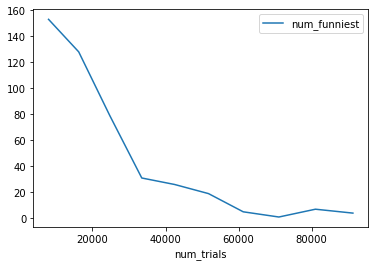

In [16]:
funniest_df = pd.DataFrame(funniest_table, columns=["num_trials", "num_funniest"])
funniest_df.plot.line(x='num_trials', y='num_funniest')
